In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
from utils import filt_decompose

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'


In [3]:
ncfile = '/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_RAW_2023_60s.nc'
ds = xr.open_dataset(ncfile)
ds

<xarray.Dataset>
Dimensions:  (time: 523799)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T00:00:00.220000 ... 2023-12-30T...
Data variables:
    airgap   (time) float64 ...

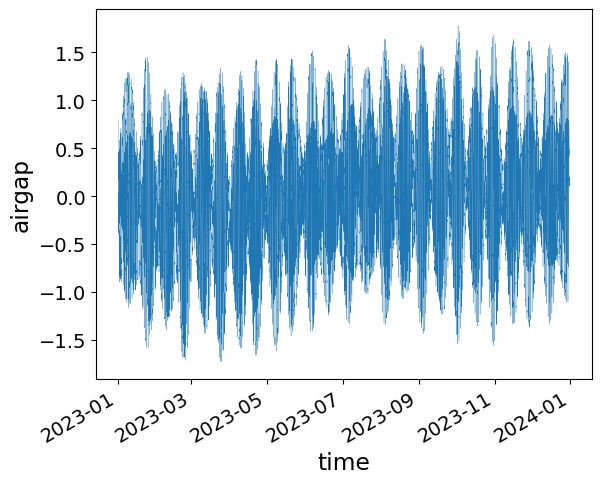

In [4]:
ds['airgap'].plot(lw=0.2)

In [5]:
time = ds.time.values

time_utc = time - np.timedelta64(8*3600, 's')

dt = (time[1:]-time[:-1]).mean()
dtsec = dt.astype(float)*1e-9

# Important ssh = -1*airgap i.e. airgap grows when water level drops
ssh  = -ds['airgap']
ssh['time'] = time_utc
yf = filt_decompose(ssh, dtsec)

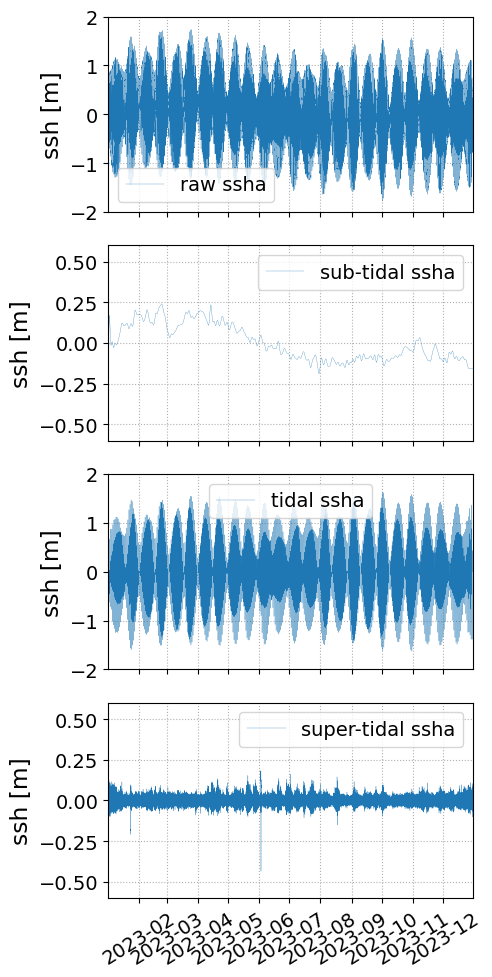

In [6]:
plt.figure(figsize=(5,10))

ax0 = plt.subplot(411)
ssh.plot(lw=0.2, label='raw ssha')
ax0.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2.,2.)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.xlabel('')
plt.legend()

ax1 = plt.subplot(412,)
plt.plot(time, yf[:,0], lw=0.2, label='sub-tidal ssha')
ax1.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-0.6, 0.6)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()

ax2 = plt.subplot(413,)
plt.plot(time, yf[:,1], lw=0.2, label='tidal ssha')
ax2.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2., 2.)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()

ax3 = plt.subplot(414, )
plt.plot(time, yf[:,2], lw=0.2, label='super-tidal ssha')
plt.xticks(rotation=32)
plt.xlim(time[0], time[-1])
plt.ylim(-0.6, .6)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()

plt.tight_layout()
plt.savefig('../FIGURES/NRA_AirGap_FilteredData.png')

In [7]:
from nwatides import fes, hanalysis

## NRA location

https://apps.sentinel-hub.com/eo-browser/?zoom=18&lat=-19.58356&lng=116.13691&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fservices.sentinel-hub.com%2Fogc%2Fwms%2Fbd86bcc0-f318-402b-a145-015f85b9427e&datasetId=S2L2A&fromTime=2024-03-09T00%3A00%3A00.000Z&toTime=2024-03-09T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR&demSource3D=%22MAPZEN%22

In [8]:
ilon, ilat = np.array([116.1376]), np.array([-19.5842]) # NRA location
constituents, minor = None, None
h= fes.tidal_prediction(ilon, ilat, pd.DatetimeIndex(time_utc), 'z')

h_pr =  ssh - h['z_tide'][0,:]


h
#fes.load_tidal_amplitudes_np(ilon, ilat, 'z', constituents=None)

not broadcasting because len(lon)==len(lat)
Using FES2022...


<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1, time: 523799)
Coordinates:
  * lon      (lon) float64 116.1
  * lat      (lat) float64 -19.58
  * time     (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... 2023-12-30T...
Data variables:
    z_tide   (lon, time) float64 -0.4571 -0.4554 -0.4537 ... 1.092 1.094 1.096

In [108]:
from scipy import signal

def filt(ytmp, cutoff_dt, dt, btype='low', order=8, ftype='sos', axis=-1):
    """
    Butterworth filter the time series

    Inputs:
        cutoff_dt - cuttoff period [seconds]
        btype - 'low' or 'high' or 'band'
    """
    if not btype == 'band':
        Wn = 2*dt/cutoff_dt
    else:
        Wn = [2*dt/co for co in cutoff_dt]
    
    if ftype=='sos':
        sos = signal.butter(order, Wn, btype, analog=False, output='sos')
        return signal.sosfiltfilt(sos, ytmp, axis=axis)
    else:
        (b, a) = signal.butter(order, Wn, btype=btype, analog=0, output='ba')
        return signal.filtfilt(b, a, ytmp, axis=axis)


def filt_decompose(xraw, dt, b1=34*3600, b2=4*3600, order=8, ftype='sos', axis=-1):
    x1 = filt(xraw,b1, dt, btype='low', order=order, ftype=ftype, axis=-1)
    x2 = filt(xraw, [b1,b2], dt, btype='band', order=order, ftype=ftype, axis=-1)
    x3 = filt(xraw, b2, dt, btype='high', order=order, ftype=ftype, axis=-1)
    
    xin = np.vstack([x1,x2,x3]).T
    
    return xin


(19358.0, 19372.0)

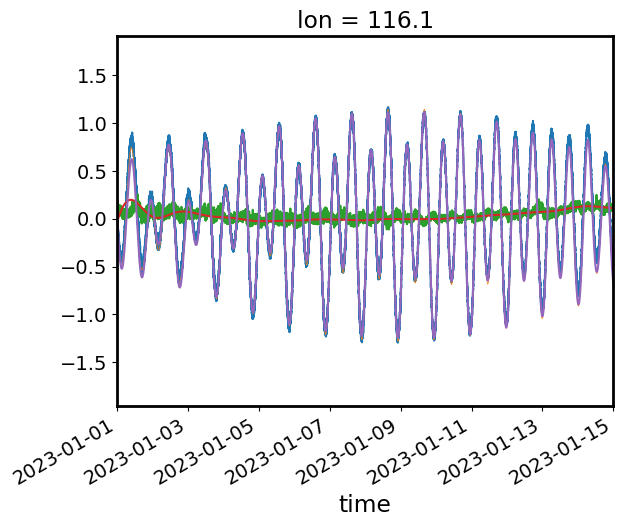

In [109]:
#yf = filt_decompose(ssh, dtsec,b1=30*3600, b2=20*3600, )
yf = filt_decompose(ssh, dtsec,b1=35*3600, b2=5*3600, order=8, ftype='sos')

fig, ax = plt.subplots(1)
ssh.plot(ax=ax)
h['z_tide'].plot(lw=0.5,ax=ax)
h_pr.plot(ax=ax)
ax.plot(time_utc, yf[:,0])
ax.plot(time_utc, yf[:,1])
ax.set_xlim(np.datetime64('2023-01-01'), np.datetime64('2023-01-15'))


In [112]:
# Compute the phase-locked component
constituents = fes.default_fes_constituents
h_lsq = hanalysis.least_square(h_pr, time_utc, constituents)
h_lsq_bp = hanalysis.least_square(yf[:,1]- h['z_tide'][0,:], time_utc, constituents)

# Output an array with
- Raw SSH
- FES SSH
- band-passed tidal residual (D1 + D2)
- phase-locked baroclinic tide
- tidal harmonic amplitudes

In [135]:
ssh_bp = xr.DataArray(yf[:,1], coords={'time':time_utc}, name='ssha_tidal_bandpass')

ds_out = xr.merge([ssh, ssh_bp, h_lsq_bp, h])
ds_out = ds_out.rename({'z_tide':'ssha_fes_2022',
                       'h':'ssha_baroclinic_tidal',
                       'h_predicted':'ssha_baroclinic_phaselocked',
                       'h_residual':'ssha_baroclinic_nonphaselocked', 
                       })
outfile = '/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_tidal_analysis.nc'
ds_out.to_netcdf(outfile)
ds_out

<xarray.Dataset>
Dimensions:                         (time: 523799, c: 34, lon: 1, lat: 1)
Coordinates:
  * time                            (time) datetime64[ns] 2022-12-31T16:00:00...
  * c                               (c) <U7 '2n2' 'eps2' 'j1' ... 'ssa' 't2'
  * lon                             (lon) float64 116.1
  * lat                             (lat) float64 -19.58
Data variables:
    ssha                            (time) float64 -0.7873 -0.5752 ... -0.1546
    ssha_tidal_bandpass             (time) float64 -0.1861 ... -1.022e-07
    h_real                          (c) float64 0.002868 0.001533 ... -0.00222
    h_imag                          (c) float64 -0.0001399 ... 0.007797
    h_real_var                      (c) float64 3.019e-09 ... 2.802e-09
    h_imag_var                      (c) float64 3.019e-09 ... 2.803e-09
    ssha_baroclinic_tidal           (time) float64 0.271 0.2747 ... -1.096
    ssha_baroclinic_phaselocked     (time) float64 -0.02697 ... -0.01097
    ssha_baroclinic_nonphaselocked  (time) float64 0.298 0.3017 ... -1.085
    ssha_fes_2022                   (lon, time) float64 -0.4571 ... 1.096

(-0.07, 0.07)

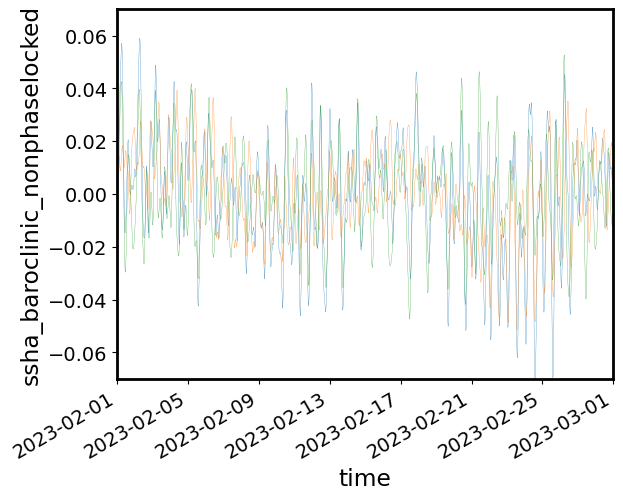

In [134]:
fig, ax = plt.subplots(1)
ds_out['ssha_baroclinic_tidal'].plot(lw=0.2)
ds_out['ssha_baroclinic_phaselocked'].plot(lw=0.2)
ds_out['ssha_baroclinic_nonphaselocked'].plot(lw=0.2)

ax.set_xlim(np.datetime64('2023-02-01'), np.datetime64('2023-03-01'))
ax.set_ylim(-0.07, 0.07)

In [118]:
h_lsq['h_real'].sel(c=['m2','s2']).values, h_lsq_bp['h_real'].sel(c=['m2','s2']).values

(array([0.00082634, 0.00189235]), array([0.00090013, 0.00177585]))

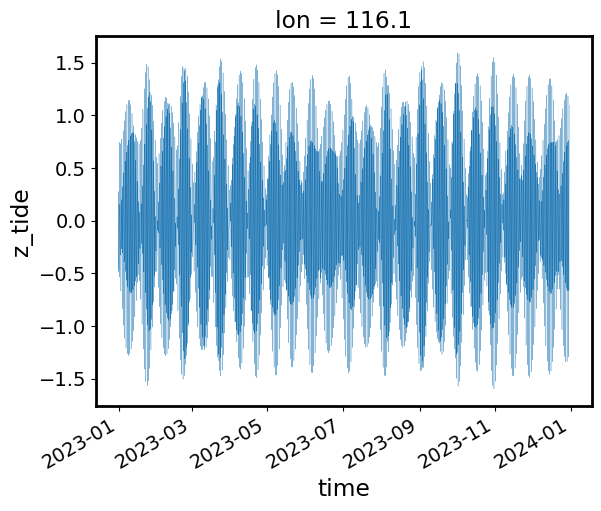

In [9]:
h['z_tide'][0,:].plot(lw=0.2)

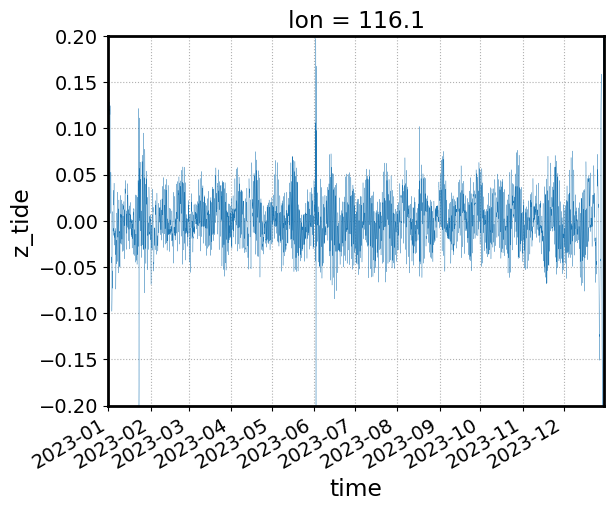

In [10]:
(h['z_tide'][0,:]-yf[:,1]).plot(lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])
plt.ylim(-0.2 ,0.2)
plt.grid(True, ls=':')
# (h['z_tide'][0,:]).plot(lw=0.2)

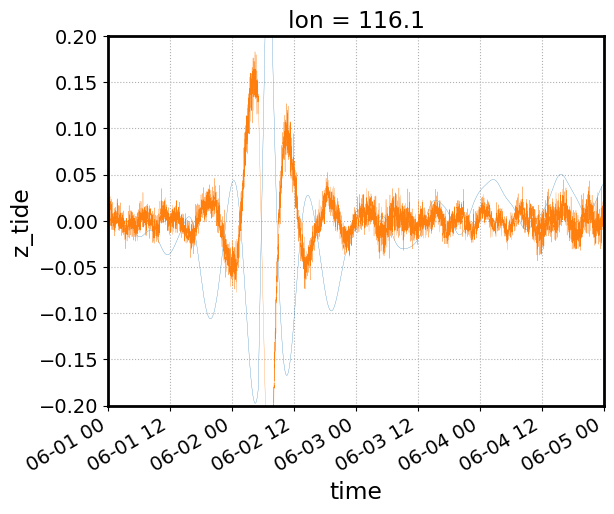

In [28]:
h_fes = h['z_tide'][0,:]
#h_residual = h_fes-yf[:,1]
h_residual = yf[:,1] - h_fes

h_residual.plot(lw=0.2)
plt.plot(time_utc, yf[:,2], lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])

plt.xlim(np.datetime64('2023-06-01'), np.datetime64('2023-06-05'))
plt.ylim(-0.2 ,0.2)
plt.grid(True, ls=':')

In [12]:
# Compute the phase-locked component
constituents = fes.default_fes_constituents
h_lsq = hanalysis.least_square(h_residual, time_utc, constituents)
h_phaselocked = h_lsq['h_predicted']
h_nonphaselocked = h_lsq['h_residual']

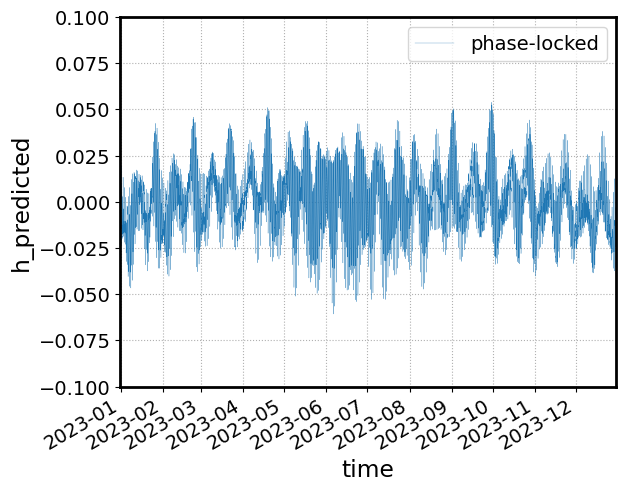

In [13]:
h_phaselocked.plot(lw=0.2, label='phase-locked')
# h_nonphaselocked.plot(lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])
# plt.xlim(np.datetime64('2023-06-01'), np.datetime64('2023-06-30'))
plt.ylim(-0.1 ,0.1)
plt.grid(True, ls=':')
plt.legend()

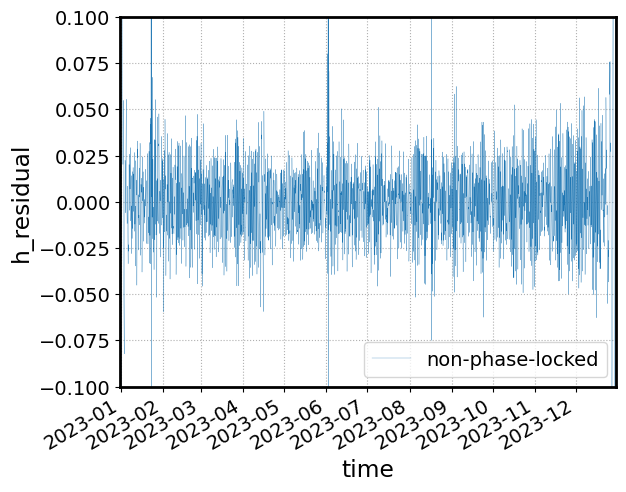

In [14]:
h_nonphaselocked.plot(lw=0.2, label='non-phase-locked')
# h_nonphaselocked.plot(lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])
# plt.xlim(np.datetime64('2023-06-01'), np.datetime64('2023-06-30'))
plt.ylim(-0.1 ,0.1)
plt.grid(True, ls=':')
plt.legend()

In [15]:
# Output dataset
h_phaselocked.name = 'h_phase_locked'
h_nonphaselocked.name = 'h_non_phase_locked'
#h_fes.name = 'h_fes2014'
h_fes.name = 'h_fes2022'

ssh.name = 'ssha'
ds_out = xr.merge([h_phaselocked, h_nonphaselocked, h_fes, ssh])
ds_out

<xarray.Dataset>
Dimensions:             (time: 523799)
Coordinates:
  * time                (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... ...
    lon                 float64 116.1
Data variables:
    h_phase_locked      (time) float64 0.02619 0.0262 0.0262 ... 0.01658 0.01655
    h_non_phase_locked  (time) float64 -0.297 -0.2997 -0.3024 ... 1.078 1.079
    h_fes2022           (time) float64 -0.4571 -0.4554 -0.4537 ... 1.094 1.096
    ssha                (time) float64 -0.7873 -0.5752 ... -0.1558 -0.1546

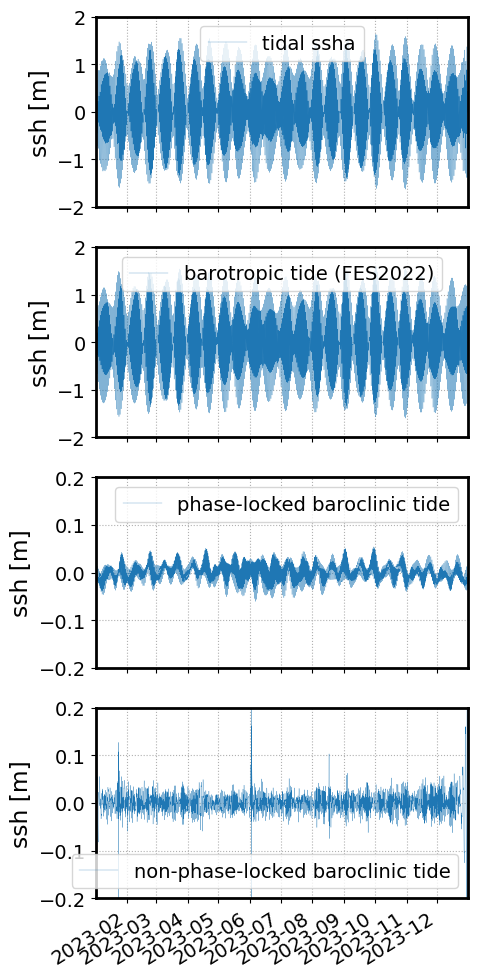

In [17]:
plt.figure(figsize=(5,10))

ax0 = plt.subplot(411)
plt.plot(time, yf[:,1], lw=0.2, label='tidal ssha')
ax0.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2.,2.)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.xlabel('')
plt.legend()

ax1 = plt.subplot(412,)
ds_out['h_fes2022'].plot(lw=0.2, label='barotropic tide (FES2022)')
ax1.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2,2)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()
plt.title('')
plt.xlabel('')

ax2 = plt.subplot(413,)
ds_out['h_phase_locked'].plot(lw=0.2, label='phase-locked baroclinic tide')
ax2.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-0.2, 0.2)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()
plt.title('')
plt.xlabel('')

ax3 = plt.subplot(414, )
ds_out['h_non_phase_locked'].plot(lw=0.2, label='non-phase-locked baroclinic tide')
plt.xticks(rotation=32)
plt.xlim(time[0], time[-1])
plt.ylim(-0.2, .2)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()
plt.title('')
plt.xlabel('')

plt.tight_layout()
plt.savefig('../FIGURES/NRA_AirGap_TidalAnalysis.png')

In [18]:
h_lsq

<xarray.Dataset>
Dimensions:      (c: 34, time: 523799)
Coordinates:
  * c            (c) <U7 '2n2' 'eps2' 'j1' 'k1' 'k2' ... 's4' 'sa' 'ssa' 't2'
  * time         (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... 2023-12...
Data variables:
    h_real       (c) float64 -0.00294 -0.001794 0.0002401 ... 0.00504 0.001965
    h_imag       (c) float64 -0.0002636 -0.0006149 ... -0.0005769 -0.008076
    h_real_var   (c) float64 4.727e-09 4.659e-09 ... 4.381e-09 4.388e-09
    h_imag_var   (c) float64 4.726e-09 4.657e-09 ... 4.352e-09 4.388e-09
    h            (time) float64 -0.2708 -0.2735 -0.2762 ... 1.092 1.094 1.096
    h_predicted  (time) float64 0.02619 0.0262 0.0262 ... 0.01658 0.01655
    h_residual   (time) float64 -0.297 -0.2997 -0.3024 ... 1.076 1.078 1.079

In [27]:
constituents = fes.default_fes_constituents
h_lsq = hanalysis.least_square(h_residual, time_utc, constituents)

# h_lsq = h_lsq.drop_vars(['h','h_predicted','h_residual'])
# h_lsq

xr.merge([ssh, h, h_lsq])

<xarray.Dataset>
Dimensions:      (time: 523799, lon: 1, lat: 1, c: 34)
Coordinates:
  * time         (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... 2023-12...
  * lon          (lon) float64 116.1
  * lat          (lat) float64 -19.58
  * c            (c) <U7 '2n2' 'eps2' 'j1' 'k1' 'k2' ... 's4' 'sa' 'ssa' 't2'
Data variables:
    ssha         (time) float64 -0.7873 -0.5752 -0.5459 ... -0.1558 -0.1546
    z_tide       (lon, time) float64 -0.4571 -0.4554 -0.4537 ... 1.094 1.096
    h_real       (c) float64 -0.00294 -0.001794 0.0002401 ... 0.00504 0.001965
    h_imag       (c) float64 -0.0002636 -0.0006149 ... -0.0005769 -0.008076
    h_real_var   (c) float64 4.727e-09 4.659e-09 ... 4.381e-09 4.388e-09
    h_imag_var   (c) float64 4.726e-09 4.657e-09 ... 4.352e-09 4.388e-09
    h            (time) float64 -0.2708 -0.2735 -0.2762 ... 1.092 1.094 1.096
    h_predicted  (time) float64 0.02619 0.0262 0.0262 ... 0.01658 0.01655
    h_residual   (time) float64 -0.297 -0.2997 -0.3024 ... 1.076 1.078 1.079

In [22]:
ds_out

<xarray.Dataset>
Dimensions:             (time: 523799)
Coordinates:
  * time                (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... ...
    lon                 float64 116.1
Data variables:
    h_phase_locked      (time) float64 0.02619 0.0262 0.0262 ... 0.01658 0.01655
    h_non_phase_locked  (time) float64 -0.297 -0.2997 -0.3024 ... 1.078 1.079
    h_fes2022           (time) float64 -0.4571 -0.4554 -0.4537 ... 1.094 1.096
    ssha                (time) float64 -0.7873 -0.5752 ... -0.1558 -0.1546

<xarray.Dataset>
Dimensions:     (time: 523799, lon: 1, lat: 1, c: 34)
Coordinates:
  * time        (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... 2023-12-...
  * lon         (lon) float64 116.1
  * lat         (lat) float64 -19.58
  * c           (c) <U7 '2n2' 'eps2' 'j1' 'k1' 'k2' ... 's4' 'sa' 'ssa' 't2'
Data variables:
    ssha        (time) float64 -0.7873 -0.5752 -0.5459 ... -0.1558 -0.1546
    z_tide      (lon, time) float64 -0.4571 -0.4554 -0.4537 ... 1.094 1.096
    h_real      (c) float64 -0.00294 -0.001794 0.0002401 ... 0.00504 0.001965
    h_imag      (c) float64 -0.0002636 -0.0006149 ... -0.0005769 -0.008076
    h_real_var  (c) float64 4.727e-09 4.659e-09 ... 4.381e-09 4.388e-09
    h_imag_var  (c) float64 4.726e-09 4.657e-09 ... 4.352e-09 4.388e-09